In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import KFold, RepeatedStratifiedKFold, StratifiedKFold
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns  
import torch

In [3]:
#Import training file
data1=pd.read_csv('../Results/PP_results/AAC_pp_cl.csv').iloc[:,2:-1].values
data2=pd.read_csv('../Results/PP_results/PAAC_pp_cl.csv').iloc[:,2:-1].values
data3=pd.read_csv('../Results/PP_results/APAAC_pp_cl.csv').iloc[:,2:-1].values
data4=pd.read_csv('../Results/PP_results/SOCN_pp_cl.csv').iloc[:,2:-1].values
data5=pd.read_csv('../Results/PP_results/GAAC_pp_cl.csv').iloc[:,2:-1].values
data6=pd.read_csv('../Results/PP_results/CKSAAGP_pp_cl.csv').iloc[:,2:-1].values
data7=pd.read_csv('../Results/PP_results/DPC_pp_cl.csv').iloc[:,2:-1].values

X1 = np.concatenate((data1, data2, data3, data4, data5, data6, data7), axis=1)
# Load the 70-dim GRU feature vectors
X2 = np.load("../features_70dim.npy")  # shape: (510, 70)

y = pd.read_csv('../Results/PP_results/AAC_pp_cl.csv').iloc[:,-1].values #labels

#Concatenate the features
X=np.concatenate((X1,X2), axis=1)

In [4]:
from sklearn.preprocessing import StandardScaler
import numpy as np

X_stand = np.array(X).reshape(-1, 140)
scaler = StandardScaler()
# X[:, 70:] = scaler.fit_transform(X[:, 70:])
X_stand = scaler.fit_transform(X_stand)

In [5]:
# Split into train (60%), val (20%), test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=26)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=26)


# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [6]:
print("Shape of the X_train is :", X_train.shape)
print("Shape of the X_test is :", X_test.shape)
print("Shape of the X_val is :", X_val.shape)
print("Shape of the y_train is :", y_train.shape)

Shape of the X_train is : torch.Size([306, 140])
Shape of the X_test is : torch.Size([102, 140])
Shape of the X_val is : torch.Size([102, 140])
Shape of the y_train is : torch.Size([306, 1])


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FusionClassifier(nn.Module):
    def __init__(self, input_dim=140, hidden_dim=64, use_two_layers=True):
        super(FusionClassifier, self).__init__()
        
        self.use_two_layers = use_two_layers
        
        # First layer
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)
        
        # Optional second layer
        if self.use_two_layers:
            self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
            self.classifier = nn.Linear(hidden_dim // 2, 1)
        else:
            self.classifier = nn.Linear(hidden_dim, 1)

    def forward(self, x):  # x: [batch_size, 140]
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        if self.use_two_layers:
            x = F.relu(self.fc2(x))
            x = self.dropout(x)

        logits = self.classifier(x)  # [batch_size, 1]
        return logits

In [8]:
#Define loss fxn and optimizer
model = FusionClassifier(input_dim=140, hidden_dim=64, use_two_layers=True)
criterion = nn.BCEWithLogitsLoss()  # use logits, not sigmoid
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

#Training Loop
num_epochs = 100
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    logits = model(X_train)
    loss = criterion(logits, y_train)
    loss.backward()
    optimizer.step()
    
    # Training accuracy
    with torch.no_grad():
        train_probs = torch.sigmoid(logits)
        train_preds = (train_probs >= 0.5).int()
        train_acc = (train_preds == y_train.int()).float().mean().item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_logits = model(X_val)
        val_loss = criterion(val_logits, y_val)
        val_probs = torch.sigmoid(val_logits)
        val_preds = (val_probs >= 0.5).int()
        val_acc = (val_preds == y_val.int()).float().mean().item()

    # Store losses and accuracies
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1:3d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch   1 | Train Loss: 0.6989 | Val Loss: 0.6850 | Train Acc: 0.5261 | Val Acc: 0.6078
Epoch   2 | Train Loss: 0.6880 | Val Loss: 0.6738 | Train Acc: 0.6373 | Val Acc: 0.9118
Epoch   3 | Train Loss: 0.6806 | Val Loss: 0.6645 | Train Acc: 0.7059 | Val Acc: 0.8627
Epoch   4 | Train Loss: 0.6651 | Val Loss: 0.6552 | Train Acc: 0.8268 | Val Acc: 0.8431
Epoch   5 | Train Loss: 0.6573 | Val Loss: 0.6459 | Train Acc: 0.8039 | Val Acc: 0.8235
Epoch   6 | Train Loss: 0.6531 | Val Loss: 0.6371 | Train Acc: 0.8039 | Val Acc: 0.8235
Epoch   7 | Train Loss: 0.6458 | Val Loss: 0.6286 | Train Acc: 0.7974 | Val Acc: 0.8137
Epoch   8 | Train Loss: 0.6335 | Val Loss: 0.6200 | Train Acc: 0.7941 | Val Acc: 0.7941
Epoch   9 | Train Loss: 0.6245 | Val Loss: 0.6111 | Train Acc: 0.8039 | Val Acc: 0.7843
Epoch  10 | Train Loss: 0.6226 | Val Loss: 0.6017 | Train Acc: 0.7680 | Val Acc: 0.7941
Epoch  11 | Train Loss: 0.6106 | Val Loss: 0.5920 | Train Acc: 0.7843 | Val Acc: 0.8039
Epoch  12 | Train Loss: 0.5997 |

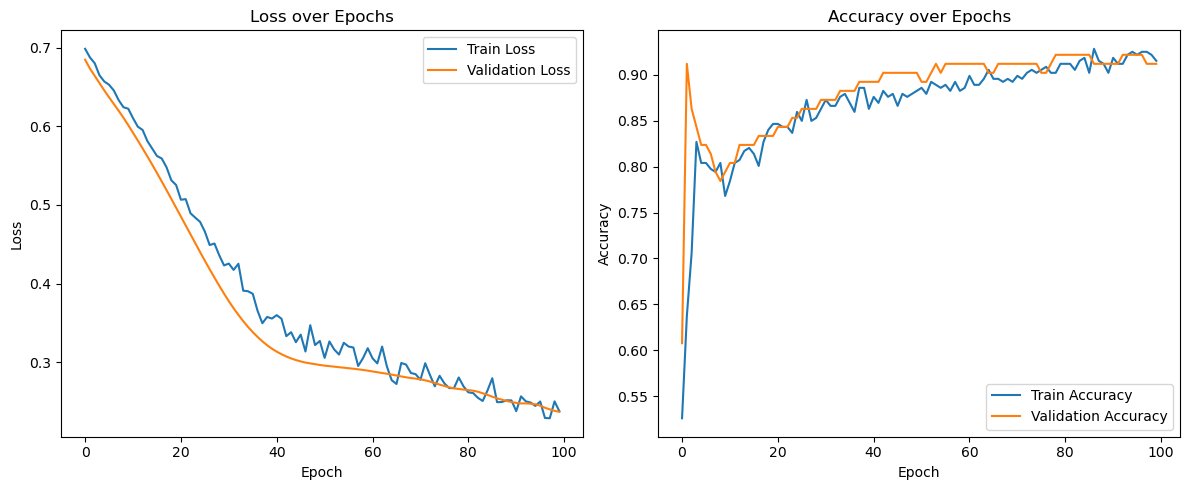

In [10]:
# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
#plt.savefig("training_validation_curves.png", dpi=600)
plt.show()

In [11]:
from sklearn.metrics import (
    recall_score, confusion_matrix, matthews_corrcoef, roc_auc_score
)

with torch.no_grad():
    logits = model(X_test)
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).int()

    # Accuracy
    accuracy = (preds == y_test.int()).float().mean().item()

    # Convert for metrics
    y_true = y_test.cpu().numpy().flatten()
    y_pred = preds.cpu().numpy().flatten()
    y_prob = probs.cpu().numpy().flatten()

    # Metrics
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    recall = recall_score(y_true, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    mcc = matthews_corrcoef(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    print("\n--- Final Test Performance ---")
    print(f"Accuracy    : {accuracy:.4f}")
    print(f"Recall      : {recall:.4f}")
    print(f"Specificity : {specificity:.4f}")
    print(f"MCC         : {mcc:.4f}")
    print(f"AUC         : {auc:.4f}")


--- Final Test Performance ---
Accuracy    : 0.9412
Recall      : 0.9608
Specificity : 0.9216
MCC         : 0.8830
AUC         : 0.9912
